# CiteLearn Model
This workbook steps through the creation of a model for detecting sentences which need citations.

It draws on Wikipedia Featured Article content prepared as detailed at https://github.com/thelondonsimon/citelearn-model

A pre-trained BERT word embedding model is used to process each sentence and this representation is used predict each sentence's 'Citation Needed' flag.


In [1]:
!pip install -q tensorflow-text tf-models-official

     |████████████████████████████████| 4.3 MB 13.4 MB/s 
     |████████████████████████████████| 1.6 MB 39.0 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 99 kB 6.7 MB/s 
     |████████████████████████████████| 636 kB 38.9 MB/s 
     |████████████████████████████████| 1.2 MB 44.5 MB/s 
     |████████████████████████████████| 352 kB 43.4 MB/s 
     |████████████████████████████████| 211 kB 52.6 MB/s 
     |████████████████████████████████| 37.1 MB 47 kB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 679 kB 39.1 MB/s 


In [2]:
import math
import datetime
import os

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import matplotlib.pyplot as plt
from google.colab import drive

import pandas as pd
import numpy as np

In [3]:
# the training data used in this notebook comes from Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Example Data
The example data for the model comes from the sample Wikipedia feature articles collected in the development of the original citation-needed model.

In [20]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# this model only makes use of the Sentence and HasCitation flags for its predictions
fa = pd.read_csv("/content/gdrive/MyDrive/citelearn/data/featured_articles/fa-sentences.txt",
                     sep="\t",
                     header = 0,
                     names = ['ArticleId','H2Heading','H3Heading','H2Idx','H3Idx','ParIdx','SenIdx','Sentence','HasCitation','ParHasCitation','PrevSenHasCitation','NextSenHasCitation'],
                     usecols = [7,8]
                 )
fa["HasCitation"] = fa["HasCitation"].astype(int)

# remove any sentences with less than five words
fa['WordCount'] = fa['Sentence'].str.split().str.len()
fa = fa[fa['WordCount'] >= 5]
fa = fa.drop(columns=['WordCount'])

# Create a TensorFlow Dataset from the textual feature and label
target = fa.pop('HasCitation')
fa.dataset = tf.data.Dataset.from_tensor_slices((fa.values, target.values))

# Shuffle the dataset and split into training, validation and test
fa.dataset = fa.dataset.shuffle(len(fa.dataset)).batch(BATCH_SIZE, drop_remainder = True)

trainCount = math.floor(len(fa.dataset) * 0.6)
valCount = math.floor(len(fa.dataset) * 0.2)
testCount = len(fa.dataset) - trainCount - valCount

fa.train = fa.dataset.take(trainCount + valCount).cache().prefetch(buffer_size=AUTOTUNE)
fa.val = fa.train.skip(trainCount).cache().prefetch(buffer_size=AUTOTUNE)
fa.train = fa.train.take(trainCount).cache().prefetch(buffer_size=AUTOTUNE)
fa.test = fa.dataset.skip(trainCount + valCount).cache().prefetch(buffer_size=AUTOTUNE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


## Model Specification
The model utilises BERT preprocessing and encoding layers in the development of the final model.

In [21]:
# The model will use a Small BERT uncased model of word embeddings: bert_en_uncased_L-4_H-512_A-8
# and its matching preprocessor
bert_model_name = 'bert_en_uncased_L-4_H-512_A-8'
bert_model_ref = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
bert_preprocess_ref = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

# Uncomment to use the wiki_books BERT instead
bert_model_name = 'wiki_books'
bert_model_ref = 'https://tfhub.dev/google/experts/bert/wiki_books/2'

DROPOUT = 0.1
INIT_LR = 3e-5
OPTIMIZER = 'adamw'


# Define the model layers:
# text => preprocessing => BERT => Dropout => Dense
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(bert_preprocess_ref, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(bert_model_ref, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(DROPOUT)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)


classifier_model = build_classifier_model()

# Configure the loss, metric and optimizer for the model
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(fa.train).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

optimizer = optimization.create_optimizer(init_lr=INIT_LR,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

# compile the model
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {bert_model_name}')
history = classifier_model.fit(x=fa.train,
                               validation_data=fa.val,
                               epochs=epochs)

# evaluate the model on the test data set
testLoss, testAccuracy = classifier_model.evaluate(fa.test)

# save the model
dt = datetime.datetime.now()
modelName = 'citelearn_fa_all_bert_' + dt.strftime('%Y%m%d_%H%M')
modelPathname = '/content/gdrive/MyDrive/citelearn/models/' + modelName
classifier_model.save(modelPathname, include_optimizer=False)

Training model with wiki_books
Epoch 1/5
   88/17513 [..............................] - ETA: 8:10:45 - loss: 0.7164 - binary_accuracy: 0.5107

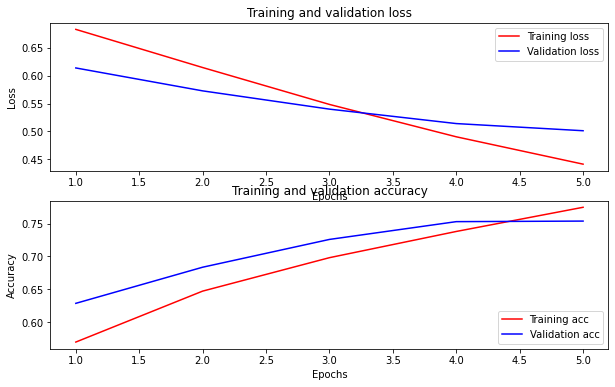

In [ ]:
# use the fit function's history to record the performance of the model
history_dict = history.history
historyDf = pd.DataFrame(data = history_dict)
historyDf['testLoss'] = testLoss
historyDf['testAccuracy'] = testAccuracy
historyDf['epoch'] = range(1,len(historyDf)+1)
historyDf['modelname'] = modelName
historyDf['datetime'] = dt.strftime('%Y%m%d %H:%M')
historyDf['config'] = 'BERT: ' + bert_model_name + ' ; Dropout: ' + "{:6.3f}".format(DROPOUT) + ' ; Init LR: ' + "{:6.5f}".format(INIT_LR) + ' ; Optimizer: adamw'
historyDf.to_csv('/content/gdrive/MyDrive/citelearn/model_performance.csv', mode='a', header=False)


# plot progress at each epoch
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
# sample prediction from the model
reloaded_model = tf.saved_model.load(modelPathname)
tf.sigmoid(reloaded_model(tf.constant(['Natasha "Tasha" Yar is a fictional character that mainly appeared in the first season of the American science fiction television series Star Trek: The Next Generation.'])))


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.01395574]], dtype=float32)>